## Imports

1. https://mxnet.incubator.apache.org/versions/master/tutorials/python/data_augmentation.html
2. https://stackoverflow.com/questions/48957333/does-mxnet-read-training-data-from-s3-in-a-streaming-fashion
3. https://mxnet.incubator.apache.org/api/python/image/image.html?highlight=imagedetiter#mxnet.image.ImageDetIter
4. https://mxnet.incubator.apache.org/api/python/gluon/data.html#mxnet.gluon.data.vision.datasets.ImageRecordDataset
5. https://mxnet.incubator.apache.org/versions/master/tutorials/gluon/data_augmentation.html
6. http://d2l.ai/chapter_computer-vision/fine-tuning.html
7. https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/
8. https://github.com/d2l-ai/d2l-en/blob/master/d2l/utils.py
9. http://d2l.ai/chapter_computer-vision/fine-tuning.html


* Fail to prepare rec file because some images were corrupted
* prepared .lst file manually
* command executed to convert images to rec


* train on small images and then bigger


In [5]:
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo
from mxnet.gluon import utils as gutils
import subprocess
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import time

import mxnet as mx
import pandas as pd
import os
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
import csv

#FOLDER = '/Users/francesco/Notebooks/personal/data/movies'
FOLDER = '/tmp/data'
#BUCKET = 's3://movies-posters-raw/'

## Data Preprocessing

In [32]:
df = pd.read_csv(os.path.join(FOLDER, 'MovieGenre.csv'), encoding='latin1')
#df = pd.read_csv(BUCKET+'MovieGenre.csv', encoding='latin1')
df = df.drop_duplicates()
df = df.loc[~pd.isnull(df.Genre)]
df.shape

(39370, 6)

In [33]:
df['split_genres'] = df.Genre.str.split('|')
df[['Genre', 'split_genres']].head()

,Genre,split_genres
0,Animation|Adventure|Comedy,"[Animation, Adventure, Comedy]"
1,Action|Adventure|Family,"[Action, Adventure, Family]"
2,Comedy|Romance,"[Comedy, Romance]"
3,Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,Comedy|Family|Romance,"[Comedy, Family, Romance]"


In [34]:
mlb = MultiLabelBinarizer()
df['labels'] = mlb.fit_transform(df.split_genres).tolist()
df[['split_genres', 'labels']].head()

,split_genres,labels
0,"[Animation, Adventure, Comedy]","[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[Action, Adventure, Family]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,"[Comedy, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Comedy, Drama, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,"[Comedy, Family, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [35]:
mlb.classes_.shape, mlb.classes_

((28,),
 array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
        'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
        'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
        'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
        'Talk-Show', 'Thriller', 'War', 'Western'], dtype=object))

In [28]:
df['lst_labels'] = df['labels'].apply(lambda x: '\t'.join([str(i) for i in x]))
df['abs_path'] = df.imdbId.apply(lambda x: os.path.join(FOLDER, 'posters', str(x) + '.jpg'))
df['check'] = df.abs_path.apply(lambda x: 0 if cv2.imread(x) is None else 1)
df['path'] = df.imdbId.astype(str) + '.jpg'

In [26]:
df = df.loc[df.check == 1]

In [37]:
raw_train = df[['imdbId', 'lst_labels', 'path']].sample(int(len(df)*.8), random_state=42)
raw_valid = df[['imdbId', 'lst_labels', 'path']].loc[~df.index.isin(raw_train.index)]

In [9]:
def save_lst(x, name):
    x.to_csv(os.path.join(FOLDER, 'temp.lst'), index=False, header=None, sep='\t')
    
    with open(os.path.join(FOLDER, 'temp.lst'), "rt") as fin:
        with open(os.path.join(FOLDER, name), "wt") as fout:
            for line in fin:
                fout.write(line.replace('"', ''))

In [11]:
raw_train.shape, raw_valid.shape

((30838, 3), (7710, 12))

In [13]:
save_lst(raw_train, 'train.lst')
save_lst(raw_valid, 'valid.lst')

In [178]:
! head /Users/francesco/Notebooks/personal/data/movies/train.lst

1474276	1	0	0	1	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1474276.jpg
438427	0	0	0	0	0	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	438427.jpg
357668	1	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	357668.jpg
79839	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	79839.jpg
380485	0	0	0	0	0	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	380485.jpg
118688	1	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	118688.jpg
52844	0	0	0	0	0	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	52844.jpg
2072933	0	0	0	0	0	1	1	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	2072933.jpg
1092006	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	1092006.jpg
351795	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	351795.jpg


In [13]:
# python /Users/francesco/anaconda3/envs/fraenv37/lib/python3.6/site-packages/mxnet/tools/im2rec.py train.lst posters/ --pack-label
# python /Users/francesco/anaconda3/envs/fraenv37/lib/python3.6/site-packages/mxnet/tools/im2rec.py valid.lst posters/ --pack-label


In [38]:
raw_train = df.sample(int(len(df)*.8), random_state=42)
raw_valid = df.loc[~df.index.isin(raw_train.index)]

In [39]:
raw_train.shape, raw_valid.shape

((31496, 8), (7874, 8))

In [76]:
raw_valid.sample()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,split_genres,labels
12325,439511,http://www.imdb.com/title/tt439511,Commune (2005),6.7,Documentary,https://images-na.ssl-images-amazon.com/images...,[Documentary],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [58]:
import numpy as np
from skimage import io


def read_image(filename):
    data = mx.nd.array(io.imread(filename))
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3,64,64),
                                    mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    data = nd.expand_dims(data, axis=0)

    return data

In [77]:
img = read_image(os.path.join(FOLDER, '439511.jpg'))

In [78]:
img = img.copyto(mx.gpu(0))

In [92]:
preds = sig(finetune_net(img))

In [93]:
preds


[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
<NDArray 1x28 @gpu(0)>

In [95]:
preds.asnumpy().squeeze().nonzero()

(array([8]),)

In [80]:
nz = preds.asnumpy().nonzero()[1]

In [84]:
mlb.classes_[nz].tolist()

['Drama']

In [83]:
mlb.classes_

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Talk-Show', 'Thriller', 'War', 'Western'], dtype=object)

## Deep Learning

In [85]:
def train_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3,64,64),
                                    rand_crop=0.5, rand_mirror=True, inter_method=10,
                                    brightness=0.125, contrast=0.125, saturation=0.125,
                                    pca_noise=0.02, mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def valid_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3,64,64),
                                    mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def standard_transform(data, label):
    data = data.astype('float32')
    augs = mx.image.CreateAugmenter(data_shape=(3, 224, 224))
    for aug in augs:
        data = aug(data)
    return data, label

def plot_mx_array(array):
    """
    Array expected to be height x width x 3 (channels), and values are floats between 0 and 255.
    """
    assert array.shape[2] == 3, "RGB Channel should be last"
    imshow((array.clip(0, 255)/255).asnumpy())
    
def show_batch(rec_file):
    dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, rec_file),
                                                     transform=standard_transform)
    loader = mx.gluon.data.DataLoader(dataset, batch_size=64, shuffle=True)
    x, y = next(iter(loader))
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):
        im = (x[i])
        id_l = y[i].asnumpy().nonzero()[0]
        labels = mlb.classes_[id_l]
        title = '/'.join(labels.tolist())
        ax.set_title(title)
        ax.set_axis_off()
        ax.imshow((im.clip(0, 255)/255).asnumpy())

In [7]:
training_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, 'train.rec'), 
                                                           transform=train_aug_transform)

validation_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, 'valid.rec'), 
                                                            transform=valid_aug_transform)

In [86]:
train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=64, shuffle=True)

In [9]:
#for x, y in train_iter:
#    print(x.shape, y.shape)
    #assert batch.data[0].shape == (1, 3, 224, 224)
    #assert batch.label[0].shape == (28,)
#    break

In [10]:
#x, y = next(iter(train_iter))

In [88]:
rec_file = 'valid.rec'
dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, rec_file),
                                                     transform=standard_transform)
loader = mx.gluon.data.DataLoader(dataset, batch_size=64, shuffle=True)
x, y = next(iter(loader))

In [91]:
y[0].asnumpy().nonzero()

(array([ 0,  6, 25]),)

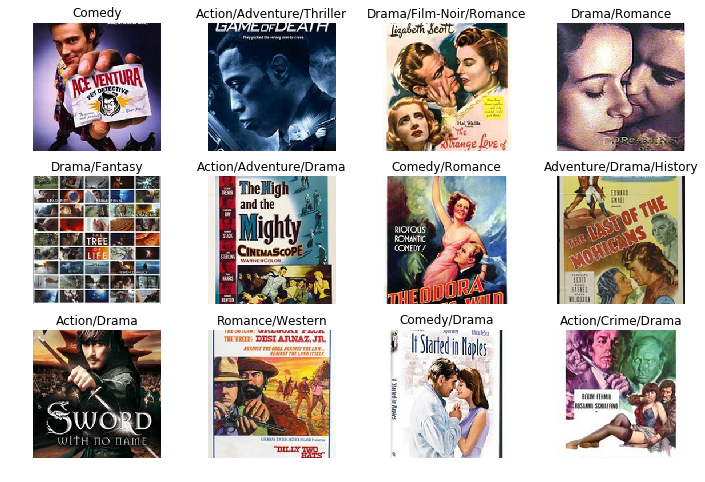

In [87]:
show_batch('valid.rec')

In [8]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)

In [9]:
finetune_net = model_zoo.vision.resnet18_v2(classes=28)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

In [10]:
def try_all_gpus():
    """Return all available GPUs, or [mx.cpu()] if there is no GPU."""
    ctxes = []
    try:
        for i in range(16):
            ctx = mx.gpu(i)
            _ = nd.array([0], ctx=ctx)
            ctxes.append(ctx)
    except mx.base.MXNetError:
        pass
    if not ctxes:
        ctxes = [mx.cpu()]
    return ctxes

def _get_batch(batch, ctx):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    """Train and evaluate a model."""
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(sig(y_hat) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc,
                 time.time() - start))

def sig(x):
    return mx.nd.sigmoid(x) > 0.5
    
        
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    """Evaluate accuracy of a model on the given data set."""
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc_sum, n = nd.array([0]), 0
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            y = y.astype('float32')
            acc_sum += (sig(net(X)) == y).sum().copyto(mx.cpu())
            n += y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar() / n

In [11]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=4):
    
    train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    test_iter = mx.gluon.data.DataLoader(validation_dataset, batch_size=batch_size)

    ctx = mx.gpu()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gloss.SigmoidBinaryCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': 0.001})
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

In [32]:
#x.shape

In [33]:
#X = mx.ndarray.random.uniform(shape=(128, 3, 64, 64)).copyto(mx.gpu())

In [34]:
#mx.nd.sigmoid(finetune_net(X)[0]) > 0.5

In [35]:
#y_hat = finetune_net(x); y_hat.shape

In [36]:
#y.shape

In [37]:
#X = finetune_net.features[1](X); X.shape

In [12]:
train_fine_tuning(finetune_net, 0.01, num_epochs=3)

training on gpu(0)
epoch 1, loss 0.3683, train acc 0.919, test acc 0.923, time 118.6 sec
epoch 2, loss 0.2209, train acc 0.923, test acc 0.923, time 110.8 sec
epoch 3, loss 0.2214, train acc 0.923, test acc 0.923, time 112.3 sec


In [9]:
#train_fine_tuning(finetune_net, 0.01)

In [10]:
#train_fine_tuning(finetune_net, 0.01, num_epochs=2)

In [1]:
from mxnettrain import *

In [1]:
channel_input_dirs = 's3://movies-posters-raw' #'/tmp/data'
hyperparameters = {'batch_size': 128, 'epochs': 5, 'learning_rate': 0.01}

In [4]:
#train(channel_input_dirs, hyperparameters)
output_path='s3://movies-posters-raw/artifacts',

In [1]:
import mxnet as mx
import sagemaker
from sagemaker.mxnet import MXNet as MXNetEstimator

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [2]:
channel_input_dirs = 's3://movies-posters-raw'
hyperparameters = {'batch_size': 128, 'epochs': 5, 'learning_rate': 0.01}

In [3]:
estimator = MXNetEstimator(entry_point='mxnettrain.py', 
            role=sagemaker.get_execution_role(), 
            train_instance_count=1, 
            framework_version=1.3,
            train_instance_type='ml.p2.xlarge',
            hyperparameters = hyperparameters)

In [4]:
estimator.fit(channel_input_dirs)

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2019-02-14-15-55-24-976


2019-02-14 15:55:25 Starting - Starting the training job...
2019-02-14 15:55:26 Starting - Launching requested ML instances...
2019-02-14 15:56:25 Starting - Preparing the instances for training.........
2019-02-14 15:57:51 Downloading - Downloading input data......
2019-02-14 15:58:53 Training - Training image download completed. Training in progress..
2019-02-14 15:58:54,379 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2019-02-14 15:58:54,407 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_INPUT_DIR': '/opt/ml/input', 'SM_USER_ENTRY_POINT': 'mxnettrain.py', 'SM_TRAINING_ENV': '{"additional_framework_parameters":{},"channel_input_dirs":{"training":"/opt/ml/input/data/training"},"current_host":"algo-1","framework_module":"sagemaker_mxnet_container.training:main","hosts":["algo-1"],"hyperparameters":{"batch_size":128,"epochs":5,"learning_rate":0.01},"input_config_dir":"/opt/ml/input/config","input_data_config":{"trainin

In [5]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2019-02-14-15-55-24-976


ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Could not find model data at s3://movies-posters-raw/artifacts/sagemaker-mxnet-2019-02-14-15-55-24-976/output/model.tar.gz.